<a href="https://colab.research.google.com/github/xinn2/deeplearning/blob/main/p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 554.8 kB/s eta 0:00:00
torch.Size([400, 600, 3])


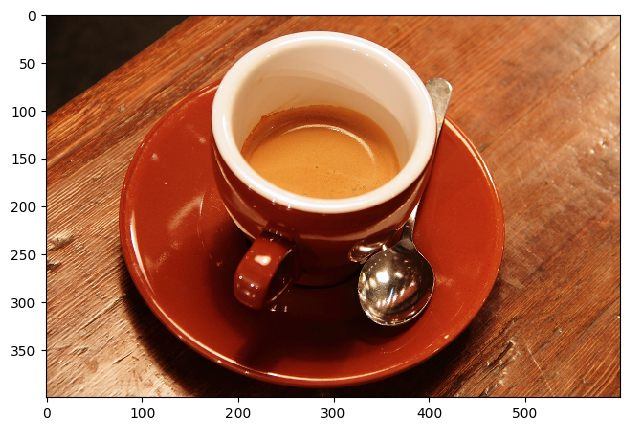

In [2]:
!pip install einops
!pip install scikit-image

import skimage
import torch
import einops

from skimage import data, io
image = data.coffee()
io.imshow(image)

x = torch.tensor(image)
x = x.float()/x.max()
print(x.size())

In [3]:
from einops import rearrange, reduce, repeat

coffee_batch = repeat(x, 'h w c -> b c h w', b=10)
print(coffee_batch.size())

torch.Size([10, 3, 400, 600])


In [4]:
from torch.nn.modules.linear import Linear
# Einops support buil-in layers
from einops.layers.torch import Rearrange, Reduce
import torch.nn as nn

class MLP(nn.Module):
  # nn.Sequential(
  #     Rearrange('b c h w -> b (c h w)'),
  #     nn.Linear(out_features=5)
  #     nn
  # )
  def __init__(self):
      super(MLP, self).__init__()
      self.layers = nn.Sequential(
          Rearrange('b c h w -> b (c h w)'),
          nn.Linear(in_features=3*400*600, out_features=5),
          nn.ReLU(),
          nn.Linear(in_features=5, out_features=1)
      )

  def forward(self, x):
    return self.layers(x)


In [5]:
net = MLP()

net(coffee_batch).size()

torch.Size([10, 1])

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


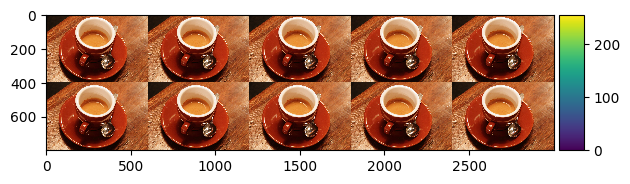

In [6]:
img_grid = rearrange(coffee_batch, '(b1 b2) c h w -> (b1 h) (b2 w) c', b1=2)
io.imshow((img_grid*255).int().numpy())

**Convolutional neural networks**

torch.Size([1, 3, 4, 4])
Number of parameters: 48
True


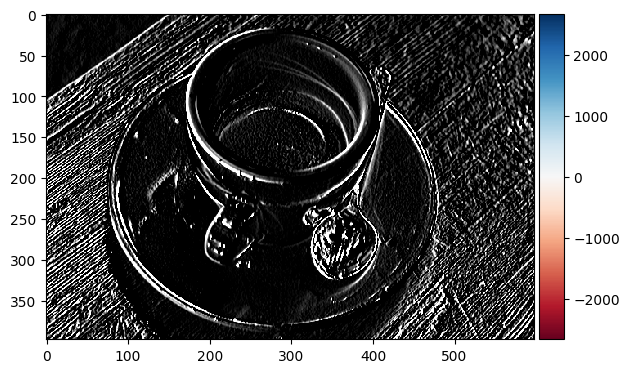

In [7]:
conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=4, bias=False)

print(conv.weight.size())
print('Number of parameters: ' + str(len(torch.nn.utils.parameters_to_vector(conv.parameters()))))
print(conv.weight.requires_grad)

w = repeat(torch.tensor([
    [-1,0.,1],
    [-2,0.,2],
    [-1,0.,1]
  ]), 'h w -> out_f in_f h w', out_f=1, in_f=3)

conv.weight.data = w
out = conv(coffee_batch)

io.imshow((repeat(out[0,0], 'h w -> h w c', c=3)*255).int().numpy())

Convolutional encoder

In [8]:
# 5 layer convolutional encoder
# B x 3 x 32 x 32 -> B x 1024 x 1 x 1
# if training to classify textures, more channels at earlier stages
# if training to detect happy/sad facial expressions, more channels in later layers

x0 = torch.zeros(10, 3, 32, 32)
c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
x1 = c1(x0)
print(x1.size())

c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
x2 = c2(x1)
print(x2.size())

c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
x3 = c3(x2)
print(x3.size())

c4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
x4 = c4(x3)
print(x4.size())

c5 = nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=4, stride=2, padding=1)
x5 = c5(x4)
print(x5.size())

print('c1 Parameters: ' + str(len(torch.nn.utils.parameters_to_vector(c1.parameters()))))
print('c2 Parameters: ' + str(len(torch.nn.utils.parameters_to_vector(c2.parameters()))))
print('c3 Parameters: ' + str(len(torch.nn.utils.parameters_to_vector(c3.parameters()))))
print('c4 Parameters: ' + str(len(torch.nn.utils.parameters_to_vector(c4.parameters()))))
print('c5 Parameters: ' + str(len(torch.nn.utils.parameters_to_vector(c5.parameters()))))

torch.Size([10, 32, 16, 16])
torch.Size([10, 64, 8, 8])
torch.Size([10, 128, 4, 4])
torch.Size([10, 256, 2, 2])
torch.Size([10, 1024, 1, 1])
c1 Parameters: 1568
c2 Parameters: 32832
c3 Parameters: 131200
c4 Parameters: 524544
c5 Parameters: 4195328


In [14]:
# encoder class
class ResidualBlock(nn.Module):
  def __init__(self, n):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
      nn.Conv2d(n,n,3,1,1),
      nn.BatchNorm2d(n),
      nn.ReLU(),
      nn.Conv2d(n,n,3,1,1),
      nn.BatchNorm2d(n)
    )
  def forward(self, x):
    return torch.relu(x + self.block(x))

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1),
        ResidualBlock(32),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
        ResidualBlock(64),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
        ResidualBlock(128),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
        ResidualBlock(256),
        nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=4, stride=2, padding=1)
    )

  def forward(self, x):
    return self.layers(x)

net = Encoder()
print(net(x0).size()) #[10, 1024, 1, 1]
# printing no. of parameters
print('Parameters: ' + str(len(torch.nn.utils.parameters_to_vector(net.parameters()))))

torch.Size([10, 1024, 1, 1])
Parameters: 6455072


In [17]:
# decoder
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(1024, 256, 4, 2, 1),
        ResidualBlock(256),
        nn.ConvTranspose2d(256, 128, 4, 2, 1),
        ResidualBlock(128),
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        ResidualBlock(64),
        nn.ConvTranspose2d(64, 32, 4, 2, 1),
        ResidualBlock(32),
        nn.ConvTranspose2d(32, 3, 4, 2, 1)
    )

  def forward(self, x):
    return self.layers(x)

en = Encoder()
de = Decoder()
a = en(x0)
out = de(a)
print(out.size())
print('Parameters: ' + str(len(torch.nn.utils.parameters_to_vector(de.parameters()))))

torch.Size([10, 3, 32, 32])
Parameters: 6454051


In [20]:
# creating Autoencoder class
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

auto = Autoencoder()
auto(x0)
print(auto(x0).size())

torch.Size([10, 3, 32, 32])
